# Speech Emotion Recognition (CREMA Dataset)

## 0. Problem Statement

The main goal of this lab is to build a CNN model that detects human emotions from speech using the CREMA dataset, by turning speech clips into features that can help a computer recognize emotions like humans do.

## 1. Imports and Utilities

In [123]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML
from collections import defaultdict
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import random
import torch
from torch import nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from itertools import product
from sklearn.metrics import f1_score, confusion_matrix,  ConfusionMatrixDisplay, accuracy_score

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns

2025-05-14 18:14:37.136439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747246477.701338      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747246477.833671      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [115]:
# configurations
SEED = 42
SAMPLE_RATE = 22050 # number of audio samples captured per second
FRAME_LENGTH = 2048 # number of samples per analysis frame
HOP_LENGTH = 512    # samples between consecutive frame starts 
                    # instead of jumping the frame length we jump 512 so that the frames overlap to get smooth detailed analysis
DURATION = 3
TARGET_LENGTH = SAMPLE_RATE * DURATION
# compute the exact number of frames for 3s clips which will be (3*22050)/512 = 130
N_FRAMES = int(np.ceil(TARGET_LENGTH / HOP_LENGTH))
EMOTION_MAP = {
    'ANG': 'Angry', 'DIS': 'Disgust', 'FEA': 'Fear',
    'HAP': 'Happy', 'NEU': 'Neutral', 'SAD': 'Sad'
}
# os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Dataset Loading and Visualizing

In [118]:
class Cust_DataLoader:
    def __init__(self,audio_dir="../input/crema-dataset/Crema"):
        self.audio_dir = audio_dir
        self.file_groups = defaultdict(list)
        self.emotion_colors = {
            "ANG":"#d62728", "DIS":"#2ca02c","FEA":"#7f7f7f",
            "HAP":"#ff7f0e", "NEU":"#1f77b4","SAD":"#9467bd"
        }
        self.load_dataset()
        self.print_dataInfo_report()

    def load_dataset(self):
        n_files = 0
        for file_name in sorted(os.listdir(self.audio_dir)):
            if file_name.endswith('.wav'):
                parts = file_name.split("_")
                base_id = "_".join(parts[:2])
                emotion = parts[2]
                full_path = os.path.join(self.audio_dir,file_name)

                self.file_groups[base_id].append((emotion,full_path))
                n_files += 1
        print(f"Loaded {n_files} audio files")
        self.filter_groups()

    def filter_groups(self):
        self.file_groups = {k: v for k,v in self.file_groups.items() if len({item[0] for item in v}) > 1}

    def print_dataInfo_report(self):
        emotion_counts = defaultdict(int)
        for i in self.file_groups.values():
            for emotion, _ in i:
                emotion_counts[emotion] +=1

        display(HTML(
            f"<h2 style='color:#2c3e50; border-bottom: 3px solid #3498db;'>"
            "Dataset Info Report</h2>"
            f"<p style='font-size:16px;'>"
            f"Groups: {len(self.file_groups)}<br>"
            f"Emotion distribution:<br>"
            + "<br>".join([f" • {e}: {c} samples" for e,c in emotion_counts.items()]) +
            "</p>"
        ))

    def load_audio(self,path):
        signal,_ = librosa.load(path,sr=SAMPLE_RATE,duration=DURATION)
        return librosa.util.fix_length(signal,size=TARGET_LENGTH)
    
    def display_audio(self,signal,emotion):
        display(HTML(
            f"<div style='margin:10px 0; padding-left:8px; border-left: 3px solid {self.emotion_colors[emotion]}'>"
            f"<span style='color:{self.emotion_colors[emotion]}; font-weight:bold;'>{EMOTION_MAP[emotion]}</span> sample:"
            "</div>"
        ))
        display(Audio(data=signal,rate=SAMPLE_RATE))
    
    def plot_waveforms(self, n_groups=1):
        # plot all emotions with waveform for the same audio id
        groups = list(self.file_groups.keys())
        rng = np.random.default_rng(SEED)
        selected_groups = rng.choice(groups, size=min(n_groups, len(groups)), replace=False)

        for group_id in selected_groups:
            group_data = self.file_groups[group_id]
            emotions = [item[0] for item in group_data]
            
            # first pass load all signals and find global amplitude range
            signals = []
            global_max = 0
            for emotion, path in group_data:
                signal = self.load_audio(path)
                signals.append(signal)
                current_max = np.max(np.abs(signal))
                global_max = max(global_max, current_max)
            
            # 10% padding to amplitude range
            y_min = -global_max * 1.1
            y_max = global_max * 1.1
            
            # plots
            fig = plt.figure(figsize=(12, 3 * len(emotions)), dpi=100, 
                            constrained_layout=True)
            fig.suptitle(f"Emotion Waveforms: {group_id}", y=1.02, 
                        fontsize=16, fontweight='bold')
            
            for i, ((emotion, path), signal) in enumerate(zip(group_data, signals), 1):
                ax = fig.add_subplot(len(emotions), 1, i)
                time = np.linspace(0, DURATION, len(signal))
                
                ax.plot(time, signal, 
                        color=self.emotion_colors[emotion],
                        alpha=0.8,
                        linewidth=1.2)
                
                ax.set_title(f"{emotion} - {EMOTION_MAP[emotion]}",
                            color=self.emotion_colors[emotion],
                            fontsize=12,
                            pad=20,  
                            loc='left',
                            y=1.05,  
                            fontweight='bold')

                ax.set_ylim(y_min, y_max)
                ax.set_xlim(0, DURATION)
                ax.set_xlabel("Time (seconds)" if i == len(emotions) else "",
                            fontsize=10)
                ax.set_ylabel("Amplitude", fontsize=10)
                ax.tick_params(axis='both', labelsize=8)
                ax.grid(True, alpha=0.3)
                
                self.display_audio(signal, emotion)

            plt.show()
    def plot_mel_spectrograms(self):
        # grouping files by emotion
        emotion_files = defaultdict(list)
        for group in self.file_groups.values():
            for emotion, path in group:
                emotion_files[emotion].append(path)
        
        emotions = sorted(emotion_files.keys())  # sorted list of emotions
        n_cols = 3
        n_rows = int(np.ceil(len(emotions) / n_cols))
        
        fig = plt.figure(figsize=(16, 4.5 * n_rows), dpi=120)
        gs = fig.add_gridspec(n_rows, n_cols, hspace=0.35, wspace=0.15)
        
        extractor = FeatureExtraction()
        rng = np.random.default_rng(SEED)
        mel_data = []
        for emotion in emotions:
            path = rng.choice(emotion_files[emotion])
            signal = self.load_audio(path)
            mel_spec = extractor.extract_mel_spectrogram(signal).squeeze()
            mel_data.append((emotion, mel_spec))

        vmin = min(np.min(mel) for _, mel in mel_data)
        vmax = max(np.max(mel) for _, mel in mel_data)

        for idx, (emotion, mel_spec) in enumerate(mel_data):
            row = idx // n_cols
            col = idx % n_cols
            ax = fig.add_subplot(gs[row, col])
 
            time_points = np.linspace(0, mel_spec.shape[1], num=4)
            time_labels = [f"{t:.1f}" for t in np.linspace(0, DURATION, num=4)]

            im = ax.imshow(mel_spec, 
                          cmap='magma',
                          origin='lower',
                          aspect='auto',
                          vmin=vmin,
                          vmax=vmax)
 
            ax.set_title(EMOTION_MAP[emotion], 
                        color=self.emotion_colors[emotion],
                        fontsize=12,
                        pad=12,
                        fontweight='bold')
            ax.set_xticks(time_points)
            ax.set_xticklabels(time_labels)
            ax.set_xlabel("Time (s)", fontsize=9, labelpad=8)
            ax.set_ylabel("Mel Bin", fontsize=9, labelpad=8)
            ax.tick_params(axis='both', which='major', labelsize=8)
            ax.grid(False)

            for spine in ax.spines.values():
                spine.set_color('#34495e')
                spine.set_linewidth(0.8)

        cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        cbar = fig.colorbar(im, cax=cax)
        cbar.set_label('dB Relative to Max', fontsize=10, labelpad=10)
        cbar.ax.tick_params(labelsize=8)
        
        plt.suptitle("Mel Spectrogram\n", 
                    fontsize=16, 
                    fontweight='bold',
                    y=0.98,
                    color='#2c3e50')
        plt.show()

Loaded 7442 audio files


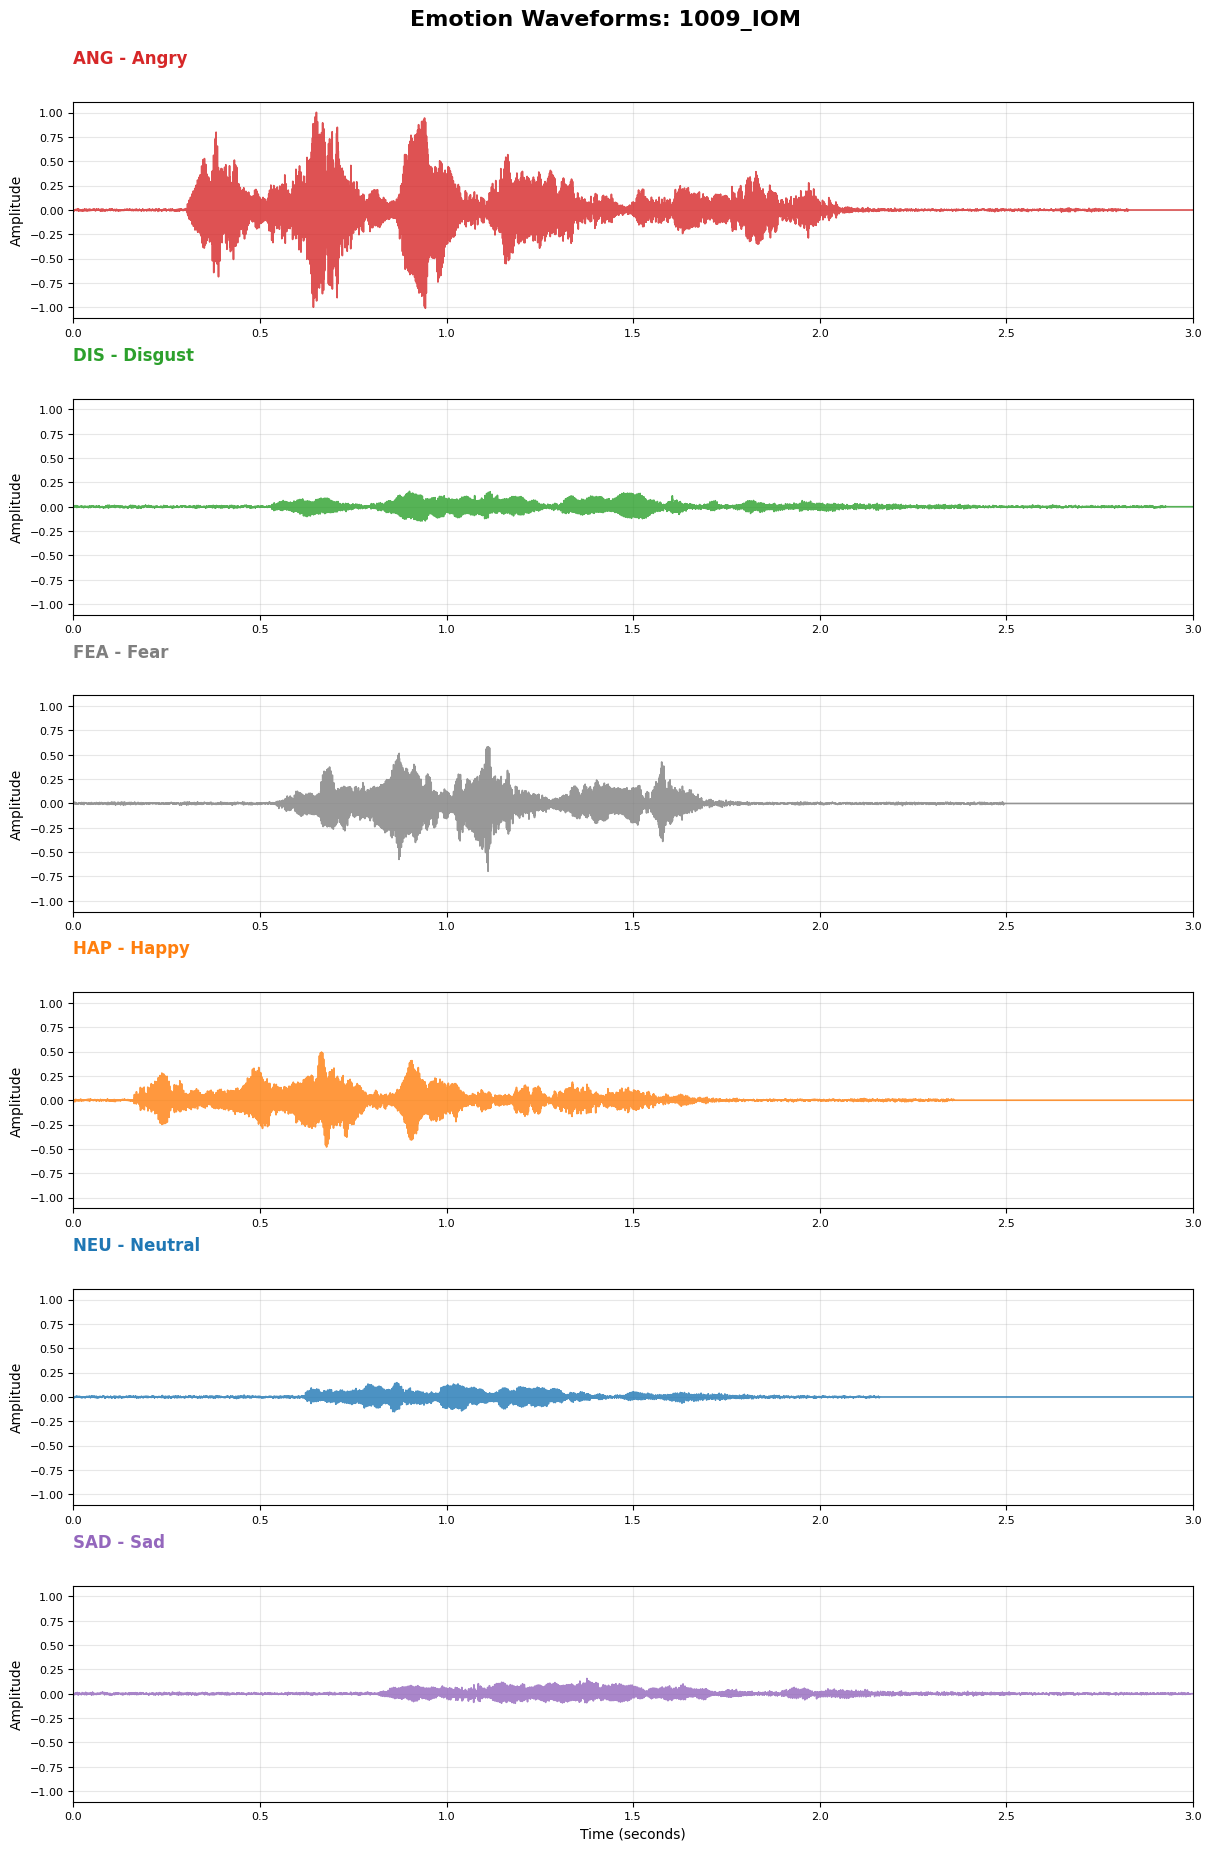

In [119]:
data_loader = Cust_DataLoader()
data_loader.plot_waveforms()

## 3. Create the Feature Space

In [98]:
class FeatureExtraction:
    def __init__(self):
        self.frame_length = FRAME_LENGTH
        self.hop_length = HOP_LENGTH
        self.n_frames = N_FRAMES
        self.sample_rate = SAMPLE_RATE

    def extract_time_features(self, signal):
        # pad/truncate features
        def pad_trunc(x):
            return np.pad(x, (0, max(0, self.n_frames - len(x))))[:self.n_frames]

        # 1. ZCR
        zcr = librosa.feature.zero_crossing_rate(
            y=signal,
            frame_length=self.frame_length,
            hop_length=self.hop_length
        )[0]

        # 2. RMS 
        rms = librosa.feature.rms(
            y=signal,
            frame_length=self.frame_length,
            hop_length=self.hop_length
        )[0]

        # 3. Spectral features
        centroid = librosa.feature.spectral_centroid(
            y=signal,
            sr=self.sample_rate,
            n_fft=self.frame_length,
            hop_length=self.hop_length
        )[0]
        # 4. Spectral bandwidth
        bandwidth = librosa.feature.spectral_bandwidth(
            y=signal,
            sr=self.sample_rate,
            n_fft=self.frame_length,
            hop_length=self.hop_length
        )[0]
        # 5. roll off
        rolloff = librosa.feature.spectral_rolloff(
            y=signal,
            sr=self.sample_rate,
            n_fft=self.frame_length,
            hop_length=self.hop_length,
            roll_percent=0.85
        )[0]

        # 6,7. Time domain statistics (std,mean) per frame
        frames = librosa.util.frame(
            signal,
            frame_length=self.frame_length,
            hop_length=self.hop_length,
            axis=0
        )
        mean = np.mean(frames, axis=0)
        std = np.std(frames, axis=0)

        # Pad/truncate all features
        zcr = pad_trunc(zcr)
        rms = pad_trunc(rms)
        centroid = pad_trunc(centroid)
        bandwidth = pad_trunc(bandwidth)
        rolloff = pad_trunc(rolloff)
        mean = pad_trunc(mean)
        std = pad_trunc(std)

        features = np.stack([zcr, rms, centroid, bandwidth, rolloff, mean, std], axis=1)
        return features

    def extract_mel_spectrogram(self, signal):
        mel_spec = librosa.feature.melspectrogram(
            y=signal,
            sr=self.sample_rate,
            n_fft=self.frame_length,
            hop_length=self.hop_length,
            n_mels=128
        )
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        resized = resize(mel_db, (128, 128), anti_aliasing=True)
        return resized[..., np.newaxis]

## 4. Build Model

### 4.1 Data Split

In [99]:
class DataSplitter:
    @staticmethod
    def split(X_time, X_mel, y, test_size=0.3, val_size=0.05, random_state=SEED):
        indices = np.arange(len(y))
        # initial train test split
        train_val_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size,
            stratify=y,
            random_state=random_state
        )

        # validation split
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=val_size/(1-test_size),
            stratify=y[train_val_idx],
            random_state=random_state
        )

        X_train_time, X_val_time, X_test_time = X_time[train_idx], X_time[val_idx], X_time[test_idx]
        X_train_mel, X_val_mel, X_test_mel = X_mel[train_idx], X_mel[val_idx], X_mel[test_idx]
        y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]
        
        return (X_train_time, X_val_time, X_test_time,
                X_train_mel, X_val_mel, X_test_mel,
                y_train, y_val, y_test)

In [100]:
# feature extraction
extractor = FeatureExtraction()
time_features = []
mel_features = []
labels = []

# collecting all data
for id, items in data_loader.file_groups.items():
    for emotion, path in items:
        signal = data_loader.load_audio(path)
        time_features.append(extractor.extract_time_features(signal))
        mel_features.append(extractor.extract_mel_spectrogram(signal))
        labels.append(emotion)

X_time = np.array(time_features)
X_mel = np.array(mel_features)

# encode labels
le = LabelEncoder().fit(labels)
y = le.transform(labels)

print("Data shapes:")
print("-" * 20)
print(f"Time features: {X_time.shape}")
print(f"Mel spectrograms: {X_mel.shape}")

Data shapes:
--------------------
Time features: (7442, 130, 7)
Mel spectrograms: (7442, 128, 128, 1)


In [101]:
# data splitting
splitter = DataSplitter()
(X_train_time, X_val_time, X_test_time,
 X_train_mel, X_val_mel, X_test_mel,
 y_train, y_val, y_test) = splitter.split(X_time, X_mel, y)

assert X_train_time.shape[1:] == (N_FRAMES, 7)
assert X_train_mel.shape[1:]  == (128, 128, 1)

print("Time features shapes:", X_train_time.shape, X_val_time.shape, X_test_time.shape)
print("Mel features shapes:", X_train_mel.shape, X_val_mel.shape, X_test_mel.shape)
print("Labels:", np.unique(y_train, return_counts=True))

Time features shapes: (4836, 130, 7) (373, 130, 7) (2233, 130, 7)
Mel features shapes: (4836, 128, 128, 1) (373, 128, 128, 1) (2233, 128, 128, 1)
Labels: (array([0, 1, 2, 3, 4, 5]), array([825, 826, 826, 826, 707, 826]))


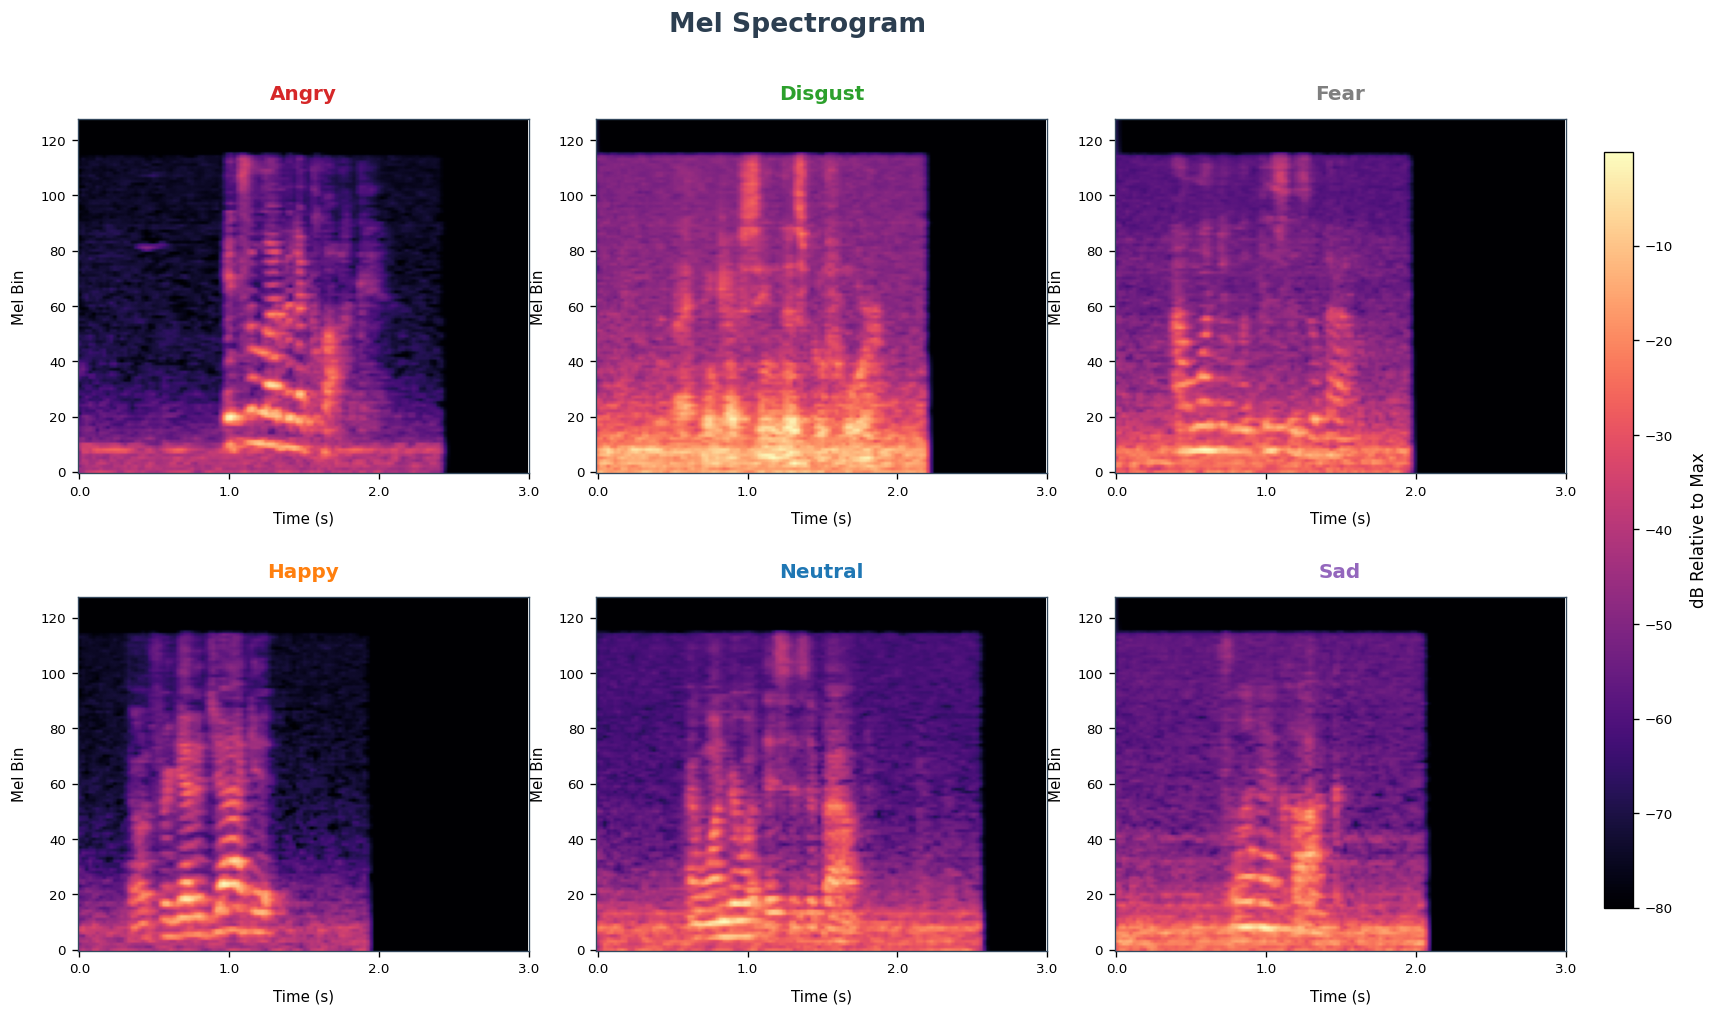

In [120]:
data_loader.plot_mel_spectrograms()

### 4.2 CNN Model

In [102]:
class CNN(nn.Module):
    def __init__(self, num_classes=6, dropout_rate = 0.2, linear_layer_size = 512):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Conv2d
        self.max_pool_layer = nn.MaxPool2d
        self.dropout_layer = nn.Dropout2d

        self.features = nn.Sequential(
            self.conv_layer(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            self.max_pool_layer(kernel_size=2, stride=2),

            self.conv_layer(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            self.max_pool_layer(kernel_size=2, stride=2),
            self.dropout_layer(dropout_rate),

            self.conv_layer(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            self.max_pool_layer(kernel_size=2, stride=2),

            self.conv_layer(256, 512, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            self.max_pool_layer(kernel_size=2, stride=2),
            self.dropout_layer(dropout_rate)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(512 * 8 *8, linear_layer_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(linear_layer_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn = CNN()
summary(cnn.cuda(), (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,664
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         204,928
              ReLU-5          [-1, 128, 64, 64]               0
         MaxPool2d-6          [-1, 128, 32, 32]               0
         Dropout2d-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 32, 32]         819,456
              ReLU-9          [-1, 256, 32, 32]               0
        MaxPool2d-10          [-1, 256, 16, 16]               0
           Conv2d-11          [-1, 512, 16, 16]       3,277,312
             ReLU-12          [-1, 512, 16, 16]               0
        MaxPool2d-13            [-1, 512, 8, 8]               0
        Dropout2d-14            [-1, 51

In [103]:
class PytorchDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        x = self.X[idx]

        if x.ndim == 3:
            x = torch.from_numpy(x).permute(2, 0, 1)
        y = torch.tensor(self.y[idx])
        return x, y

train_dataset = PytorchDataset(X_train_mel, y_train)
val_dataset = PytorchDataset(X_val_mel, y_val)
test_dataset = PytorchDataset(X_test_mel, y_test)

In [105]:
from torch.utils.data import DataLoader
hyperparameter_space = {
    "learning_rate": [1e-4, 5e-4, 1e-5],
    "batch_size": [32, 64],
    "dropout_rate": [0.2],
    "optimizer": ["Adam"],
    "linear_layer_size": [256, 512],
    # "epochs": [20, 30, 50]
    "epochs": [30, 35, 40]
}

keys = list(hyperparameter_space.keys())
values = list(hyperparameter_space.values())

g = torch.Generator()
g.manual_seed(SEED)

results = []

for i, combo in enumerate(product(*values)):
    print(f"Running Configuration Number {i + 1}/36")
    config = dict(zip(keys, combo))

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True, generator=g)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True, generator=g)

    model = CNN(dropout_rate=config["dropout_rate"], linear_layer_size=config["linear_layer_size"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Training loop
    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        predicted_list = []
        targets_list = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            predicted_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        predicted_list = []
        targets_list = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

                predicted_list.extend(predicted.cpu().numpy())
                targets_list.extend(targets.cpu().numpy())

        val_accuracy = val_correct / val_total * 100
        scheduler.step(val_loss)

    model.eval()
    test_loss = 0.0
    predicted_list = []
    targets_list = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            predicted_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    accuracy = accuracy_score(targets_list, predicted_list)
    test_f1_score = f1_score(targets_list, predicted_list, average='macro')
    cm = confusion_matrix(targets_list, predicted_list, labels=range(0, 5))
    print(accuracy)

    # Store final result for this config
    result = config.copy()
    result.update({
        'final_train_loss': epoch_loss,
        'final_train_acc': epoch_acc,
        'final_val_loss': val_loss,
        'final_val_acc': val_accuracy,
        'test_accuracy': accuracy,
        'test_f1_score': test_f1_score,
        'cm': cm
    })
    results.append(result)

Running Configuration Number 1/8
0.6157635467980296
Running Configuration Number 2/8
0.6139722346618899
Running Configuration Number 3/8
0.5987460815047022
Running Configuration Number 4/8
0.6090461262875057
Running Configuration Number 5/8
0.6157635467980296
Running Configuration Number 6/8
0.6023287057769816
Running Configuration Number 7/8
0.6139722346618899
Running Configuration Number 8/8
0.5893416927899686
Running Configuration Number 9/8
0.6032243618450515
Running Configuration Number 11/8
0.6081504702194357
Running Configuration Number 12/8
0.6081504702194357
Running Configuration Number 13/8
0.5557545902373489
Running Configuration Number 14/8
0.5553067622033139
Running Configuration Number 15/8
0.5360501567398119
Running Configuration Number 16/8
0.39767129422301833
Running Configuration Number 17/8
0.17062248096730856
Running Configuration Number 18/8
0.5347066726377071
Running Configuration Number 19/8
0.5105239587998208
Running Configuration Number 20/8
0.5391849529780565


In [106]:
results_df = pd.DataFrame(results)
results_df_excluding_a_col = results_df.drop(columns=['cm'])
styled_df = results_df_excluding_a_col.style.background_gradient(cmap='magma') \
                    .format("{:.4f}", subset=results_df_excluding_a_col.select_dtypes(include="number").columns)
styled_df

,learning_rate,batch_size,dropout_rate,optimizer,linear_layer_size,epochs,final_train_loss,final_train_acc,final_val_loss,final_val_acc,test_accuracy,test_f1_score
0,0.0001,32.0000,0.2000,Adam,256.0000,30.0000,0.4048,84.9049,17.5684,53.3512,0.6158,0.6158
1,0.0001,32.0000,0.2000,Adam,256.0000,35.0000,0.2581,90.1572,21.6642,52.8150,0.6140,0.6146
2,0.0001,32.0000,0.2000,Adam,256.0000,40.0000,0.2668,90.4880,20.9046,54.6917,0.5987,0.6003
3,0.0001,32.0000,0.2000,Adam,512.0000,30.0000,0.1965,93.4243,21.4874,54.6917,0.6090,0.6106
4,0.0001,32.0000,0.2000,Adam,512.0000,35.0000,0.2182,92.5352,19.8626,53.0831,0.6158,0.6172
5,0.0001,32.0000,0.2000,Adam,512.0000,40.0000,0.1384,95.7816,22.8728,53.8874,0.6023,0.6037
6,0.0001,64.0000,0.2000,Adam,256.0000,30.0000,0.5983,76.9851,7.5788,53.3512,0.6140,0.6158
7,0.0001,64.0000,0.2000,Adam,256.0000,35.0000,0.5643,78.1224,7.5494,54.9598,0.5893,0.5906
8,0.0001,64.0000,0.2000,Adam,256.0000,40.0000,0.2849,89.3921,9.2773,54.6917,0.6180,0.6188
9,0.0001,64.0000,0.2000,Adam,512.0000,30.0000,0.2565,91.4599,9.7802,54.9598,0.6032,0.6054


In [107]:
print("Best model:")
best_model = results_df_excluding_a_col.loc[[results_df_excluding_a_col['final_val_acc'].idxmax()]]
styled_df = best_model.style.background_gradient(cmap='magma') \
                    .format("{:.4f}", subset=best_model.select_dtypes(include="number").columns)
styled_df

Best model:


,learning_rate,batch_size,dropout_rate,optimizer,linear_layer_size,epochs,final_train_loss,final_train_acc,final_val_loss,final_val_acc,test_accuracy,test_f1_score
10,0.0001,64.0000,0.2000,Adam,512.0000,35.0000,0.3215,88.3995,8.3008,56.3003,0.6082,0.6103


### 1D MODEL

In [126]:
num_timesteps = 130
num_features  = 7
num_classes   = 6


def cnn():
    model = models.Sequential([
        layers.Input(shape=(num_timesteps, num_features)),
        layers.BatchNormalization(),

        # —---------------- block 1 ----------------------—
        layers.Conv1D(128, 3, padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.SpatialDropout1D(0.1),

        # —---------------- block 2 ----------------------—
        layers.Conv1D(256, 3, padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.SpatialDropout1D(0.25),

        # —---------------- block 3 ----------------------—
        layers.Conv1D(512, 3, padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
  

        # —---------------- block 4 ----------------------—
        layers.Conv1D(512, 3, padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.SpatialDropout1D(0.3),

        # —---------------- block 5 ----------------------—
        layers.Conv1D(1024, 3, padding='same',
                      activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.SpatialDropout1D(0.4),


        # —---------------- classification ----------------------—
        layers.GlobalAveragePooling1D(),
        layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = cnn()

optimizer = AdamW(
    learning_rate=1e-4,
    weight_decay=1e-4,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

I0000 00:00:1747246607.159077      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11486 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747246607.159777      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 130, 7)              │              28 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 130, 128)            │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 130, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 65, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 65, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 65, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 65, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 32, 256)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 32, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 16, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 16, 512)             │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 8, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 8, 512)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 8, 1024)             │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 1024)             │           4,0

 Total params: 3,526,434 (13.45 MB)

 Trainable params: 3,520,020 (13.43 MB)

 Non-trainable params: 6,414 (25.05 KB)

Epoch 1/50


I0000 00:00:1747246631.400181     190 service.cc:148] XLA service 0x7c21d400a7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747246631.401582     190 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747246631.401602     190 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747246633.005560     190 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/76 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1542 - loss: 2.9979 

I0000 00:00:1747246644.918201     190 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - accuracy: 0.2467 - loss: 2.6000 - val_accuracy: 0.1877 - val_loss: 2.1167
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3153 - loss: 2.2835 - val_accuracy: 0.1877 - val_loss: 2.2663
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3298 - loss: 2.2016 - val_accuracy: 0.1716 - val_loss: 2.1544
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3494 - loss: 2.0578 - val_accuracy: 0.1796 - val_loss: 2.1300
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3560 - loss: 2.0540 - val_accuracy: 0.3458 - val_loss: 1.8941
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3661 - loss: 1.9567 - val_accuracy: 0.3619 - val_loss: 1.8512
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3865 - loss: 1.9263 - val_accuracy: 0.3914 - val_loss: 1.7335
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3898 - loss: 1.8802 - val_accuracy: 0.4397 - val_loss: 

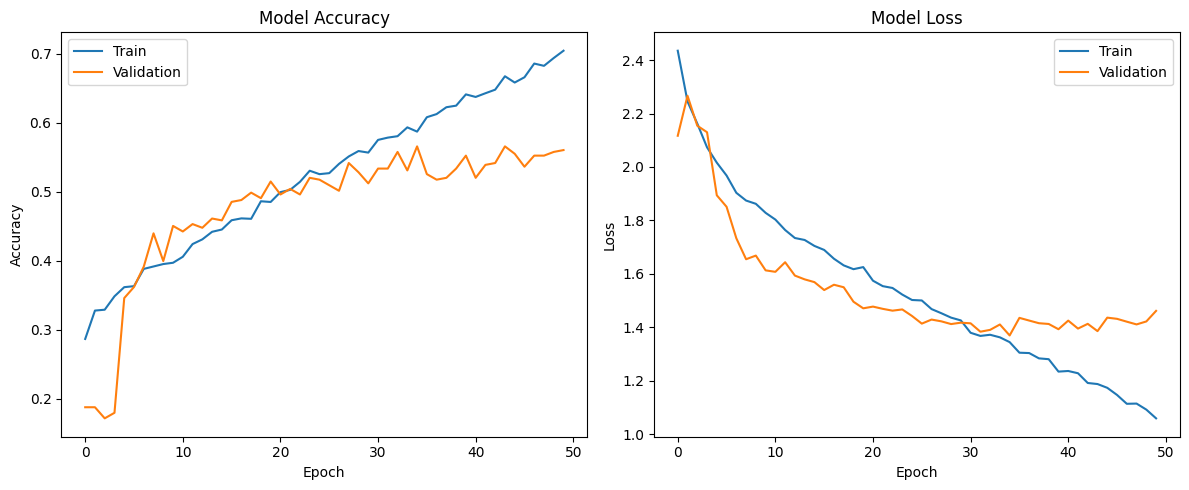


Test Accuracy: 0.5786
Test Loss: 1.4995
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Classification report:
              precision    recall  f1-score   support

       Angry       0.76      0.63      0.69       382
     Disgust       0.53      0.56      0.54       381
        Fear       0.49      0.48      0.48       381
       Happy       0.55      0.51      0.53       382
     Neutral       0.60      0.72      0.65       326
         Sad       0.58      0.59      0.59       381

    accuracy                           0.58      2233
   macro avg       0.58      0.58      0.58      2233
weighted avg       0.58      0.58      0.58      2233



In [127]:
# one hot encoding
if y_train.ndim == 1:
    ohe = OneHotEncoder(sparse_output=False)
    y_train = ohe.fit_transform(y_train.reshape(-1, 1))
    y_val = ohe.transform(y_val.reshape(-1, 1))
    y_test = ohe.transform(y_test.reshape(-1, 1))

# callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_emotion_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# ---------------training -----------------------------------------------------------
history = model.fit(
    x=X_train_time,
    y=y_train,
    validation_data=(X_val_time, y_val),
    epochs=50,
    batch_size=64,
    verbose=1
)

# ------------------trianing visualization---------------------------------
plt.figure(figsize=(12, 5))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()



# evaluate on test set
test_loss, test_acc = model.evaluate(X_test_time, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# generate predictions
y_pred = model.predict(X_test_time)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# classification report
print("\nClassification report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=EMOTION_MAP.values()))

## 5. Evaluation and Comparison

#### For 2D model

- The best model is at learning rate 0.0001, batch size = 64, dropout = 0.2, linear layer size = 512 and epoches = 35
- Train Accuracy: 0.883995
- validation Accuracy: 0.563003
- Test Accuracy: 0.6082
- F1-Score: 0.6103

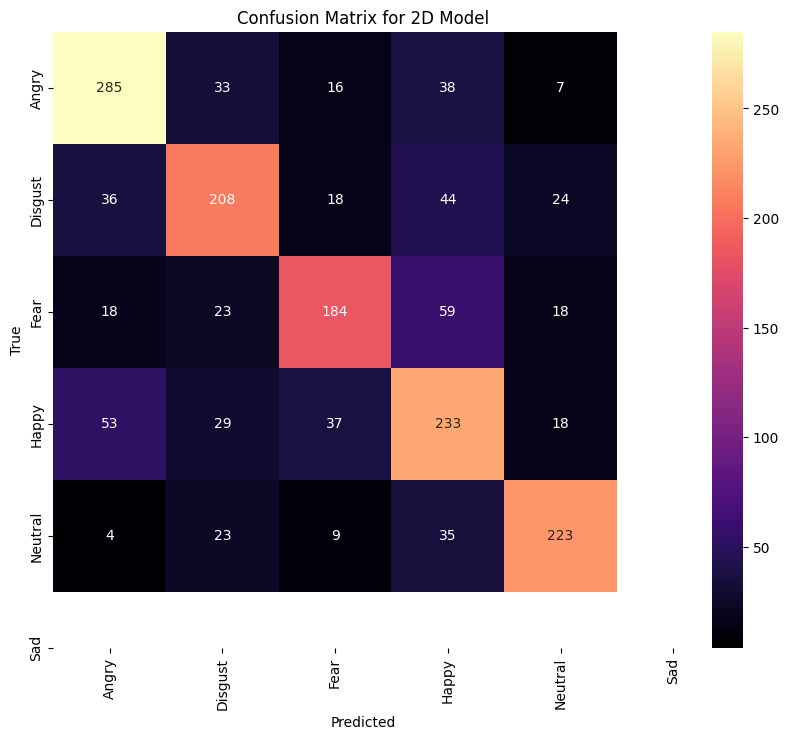

In [132]:
cm = results_df.loc[1, 'cm']

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
           xticklabels=EMOTION_MAP.values(),
           yticklabels=EMOTION_MAP.values())
plt.title('Confusion Matrix for 2D Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.show()

#### For 1D model

- The best model is at learning_rate=1e-4, weight_decay=1e-4, clipnorm=1.0 and epoches = 50
- Train Accuracy: 0.6701
- validation Accuracy: 0.5657
- Test Accuracy: 0.5786
- F1-Score: 0.58

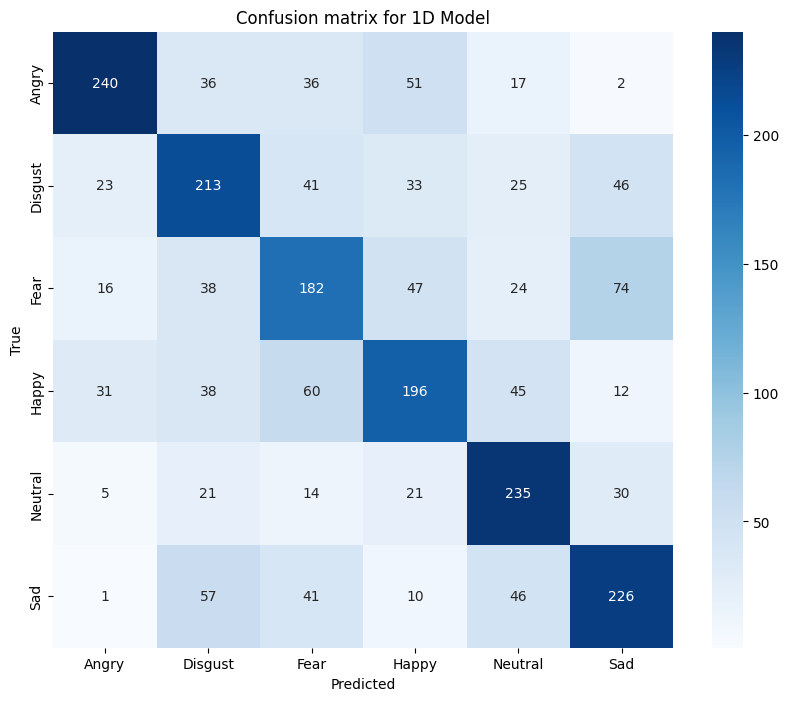

In [134]:
# confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=EMOTION_MAP.values(),
           yticklabels=EMOTION_MAP.values())
plt.title('Confusion matrix for 1D Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

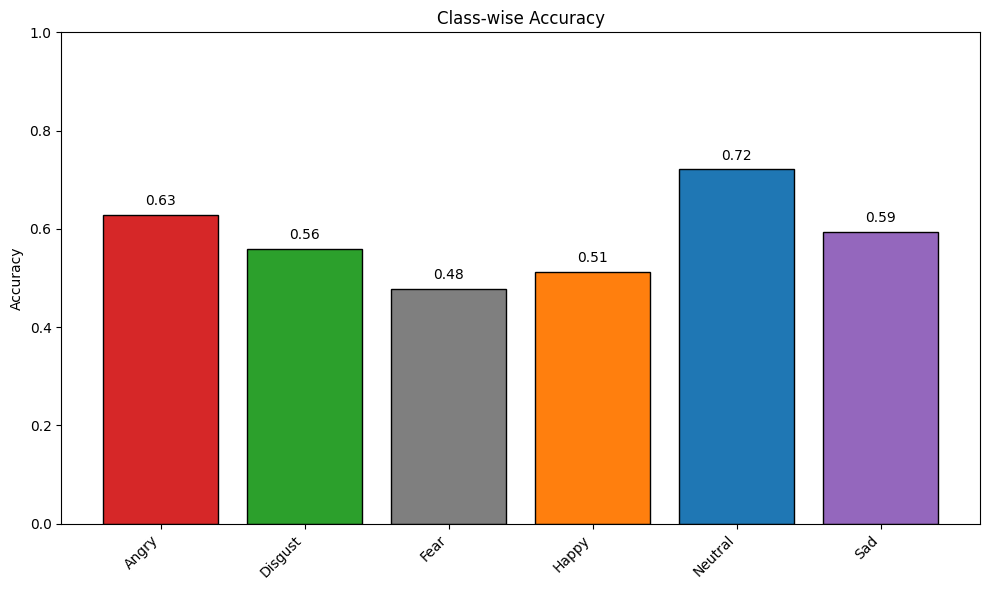

In [135]:
# computing class wise acc 
class_acc = cm.diagonal() / cm.sum(axis=1)


codes   = list(EMOTION_MAP.keys())            
labels  = [EMOTION_MAP[c] for c in codes]      
colors  = [data_loader.emotion_colors[c] for c in codes]

plt.figure(figsize=(10,6))
x = np.arange(len(labels))

plt.bar(x, class_acc, color=colors, edgecolor='k')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')

# annotations
for xi, acc in zip(x, class_acc):
    plt.text(xi, acc + 0.02, f"{acc:.2f}", ha='center')

plt.tight_layout()
plt.show()

##### The 2D model achieves higher training, validation, and testing accuracies compared to the 1D model although using the 7 extracted features. This is due to the following reasons:

- Emotions affect both pitch and energy distribution over time, which are effectively captured in spectrogram representations.
- 2D CNNs are capable of learning local frequency-time correlations more effectively than 1D CNNs.
- Spectrograms provide rich spatial information that allows the 2D model to extract more discriminative features for emotion classification.
